In [1]:
import joblib
import numpy as np
import torch

import modularised_utils as mut
import matplotlib.pyplot as plt

import opt_utils as oput

import Linear_Additive_Noise_Models as lanm
import operations as ops
from scipy.linalg import sqrtm

import params

np.random.seed(0)

In [2]:
experiment = 'synth1'

In [3]:
# Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
epsilon         = params.radius[experiment][0]
ll_num_envs     = params.n_envs[experiment][0]

delta           = params.radius[experiment][1]
hl_num_envs     = params.n_envs[experiment][1]

# Define the number of samples per environment. Currently every environment has the same number of samples
num_llsamples   = params.n_samples[experiment][0]
num_hlsamples   = params.n_samples[experiment][1]

In [4]:
Dll = mut.load_samples(experiment)[None][0] 
Gll = mut.load_ll_model(experiment)[0]
Ill = mut.load_ll_model(experiment)[1]


Dhl = mut.load_samples(experiment)[None][1] 
Ghl = mut.load_hl_model(experiment)[0]
Ihl = mut.load_hl_model(experiment)[1]

omega = mut.load_omega_map(experiment)

In [5]:
ll_coeffs = mut.get_coefficients(Dll, Gll)
hl_coeffs = mut.get_coefficients(Dhl, Ghl) 

In [6]:
# # [Not suggested] In case we want to explore also the interventional --> worse estimation!
# Dlls, Dhls = [], []
# for dpair in list(mut.load_samples(experiment).values()):
#     Dlls.append(dpair[0])
#     Dhls.append(dpair[1])
    
# ll_coeffs = mut.get_coefficients(Dlls, Gll)
# hl_coeffs = mut.get_coefficients(Dhls, Ghl) 

In [7]:
U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll, Gll, ll_coeffs)
U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl, Ghl, hl_coeffs)

In [8]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

### Barycenter

In [9]:
L_matrices = []  # List of L_i matrices
for iota in Ill:
    L_matrices.append(LLmodels[iota].compute_mechanism())

H_matrices = []  # List of H_i matrices
for eta in Ihl:
    H_matrices.append(HLmodels[eta].compute_mechanism())

mu_bary_L, Sigma_bary_L = oput.compute_gauss_barycenter(L_matrices, mu_U_ll_hat, Sigma_U_ll_hat)
mu_bary_H, Sigma_bary_H = oput.compute_gauss_barycenter(H_matrices, mu_U_hl_hat, Sigma_U_hl_hat)

print("Low-level barycenter Mean:", mu_bary_L)
print("Low-level barycenter Covariance:", Sigma_bary_L)
print( )
print("High-level barycenter Mean:", mu_bary_H)
print("High-level barycenter Covariance:", Sigma_bary_H)

Low-level barycenter Mean: [-0.00678588 -0.01069607 -0.00015191]
Low-level barycenter Covariance: [[1.04033442 0.28379336 0.03931234]
 [0.28379336 2.0108559  0.21143766]
 [0.03931234 0.21143766 0.99009455]]

High-level barycenter Mean: [ 0.0042843  -0.00863504]
High-level barycenter Covariance: [[1.35385779 0.58226716]
 [0.58226716 0.97012678]]


In [17]:
V                 = oput.sample_projection(mu_U_ll_hat.shape[0], mu_U_hl_hat.shape[0], use_stiefel=False)
mu_bary_L_proj    = V @ mu_bary_L
Sigma_bary_L_proj = V @ Sigma_bary_L @ V.T

monge, A = oput.monge_map(mu_bary_L_proj, Sigma_bary_L_proj, mu_bary_H, Sigma_bary_H)
T        = V.T @ A

In [131]:
# Ambiguity set construction: Based on epsilon and delta include distribution (as many as the num_envs) that
# pass the "gelbrich" test.
ll_moments = mut.sample_moments_U(mu_hat    = mu_U_ll_hat,
                                  Sigma_hat = Sigma_U_ll_hat,
                                  bound     = epsilon,
                                  num_envs  = ll_num_envs)

A_ll       = mut.sample_distros_Gelbrich(ll_moments) #Low-level: A_epsilon


hl_moments = mut.sample_moments_U(mu_hat    = mu_U_hl_hat,
                                  Sigma_hat = Sigma_U_hl_hat,
                                  bound     = delta,
                                  num_envs  = hl_num_envs)

A_hl       = mut.sample_distros_Gelbrich(hl_moments) #High-level A_delta

In [10]:
abstraction_errors             = {}
abstraction_env_errors         = {}
max_env_avg_interv_error_value = -np.inf
max_env_avg_interv_error_key   = None
distance_err                   = 'wass'

for lenv in A_ll:

    Dll_noise      = lenv.sample(num_llsamples)[0]
    ll_environment = mut.get_exogenous_distribution(Dll_noise)

    for henv in A_hl:
        Dhl_noise      = henv.sample(num_hlsamples)[0]
        hl_environment = mut.get_exogenous_distribution(Dhl_noise)

        total_ui_error = 0
        num_distros    = len(Ill)

        n, m  = len(LLmodels[None].endogenous_vars), len(HLmodels[None].endogenous_vars)

        T     = mut.sample_stoch_matrix(n, m)

        for iota in Ill:
            llcm   = LLmodels[iota]
            hlcm   = HLmodels[omega[iota]]
            llmech = llcm.compute_mechanism()
            hlmech = hlcm.compute_mechanism()
            error  = mut.ui_error_dist(distance_err, lenv, henv, llmech, hlmech, T)

            total_ui_error += error

        avg_interv_error = total_ui_error/num_distros

        if avg_interv_error > max_env_avg_interv_error_value:
            max_env_avg_interv_error_value = avg_interv_error
            max_env_avg_interv_error_key   = (lenv, henv)

        abstraction_errors[str(T)] = avg_interv_error
        abstraction_env_errors['ll: '+str(ll_environment.means_)+' hl: '+str(hl_environment.means_)] = avg_interv_error

/Users/giofelekis/opt/anaconda3/envs/erica/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [11]:
max_tau   = max(abstraction_errors, key=abstraction_errors.get)
max_error = abstraction_errors[max_tau]

print(f"Abstraction: {max_tau}, Error: {max_error}")
print('==============================================================================' )
max_lenv = max_env_avg_interv_error_key[0]
max_henv = max_env_avg_interv_error_key[1]

print(f"max LL mean vector = {max_lenv.means_}")
print(f"max LL covariance = {max_lenv.covariances_}")
print( )

print(f"max HL mean vector = {max_henv.means_}")
print(f"max HL covariance = {max_henv.covariances_}")
print('==============================================================================' )
print(f"max environment, average interventional abstraction error = {max_env_avg_interv_error_value}")

Abstraction: [[0.21761458 0.78238542]
 [0.75095088 0.24904912]
 [0.86664525 0.13335475]], Error: 1.080267499893765
max LL mean vector = [[0.03909886 0.02270429 0.149256  ]]
max LL covariance = [[[0.82603265 0.         0.        ]
  [0.         2.03002425 0.        ]
  [0.         0.         0.84745966]]]

max HL mean vector = [[ 0.07752375 -0.03284999]]
max HL covariance = [[[1.03175598 0.        ]
  [0.         0.77764308]]]
max environment, average interventional abstraction error = 1.080267499893765


In [41]:
experiments     = ['synth1_gnd', 'little_lucas']

for experiment in experiments:

    # Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
    epsilon         = params.radius[experiment][0]
    ll_num_envs     = params.n_envs[experiment][0]

    delta           = params.radius[experiment][1]
    hl_num_envs     = params.n_envs[experiment][1]

    # Define the number of samples per environment. Currently every environment has the same number of samples
    num_llsamples   = params.n_samples[experiment][0]
    num_hlsamples   = params.n_samples[experiment][1]

    Dll = mut.load_samples(experiment)[None][0] 
    Gll = mut.load_ll_model(experiment)[0]
    Ill = mut.load_ll_model(experiment)[1]


    Dhl = mut.load_samples(experiment)[None][1] 
    Ghl = mut.load_hl_model(experiment)[0]
    Ihl = mut.load_hl_model(experiment)[1]

    omega = mut.load_omega_map(experiment)

    ll_coeffs = mut.get_coefficients(Dll, Gll)
    hl_coeffs = mut.get_coefficients(Dhl, Ghl) 
    num_experiments = 100


Epoch 1/100, Objective: 0.1436629295349121
Epoch 2/100, Objective: 0.12592244148254395
Epoch 3/100, Objective: 0.1097555160522461
Epoch 4/100, Objective: 0.09518861770629883
Epoch 5/100, Objective: 0.08223152160644531
Epoch 6/100, Objective: 0.0708765983581543
Epoch 7/100, Objective: 0.06108880043029785
Epoch 8/100, Objective: 0.052803754806518555
Epoch 9/100, Objective: 0.045920610427856445
Epoch 10/100, Objective: 0.0402987003326416
Epoch 11/100, Objective: 0.03576302528381348
Epoch 12/100, Objective: 0.03211045265197754
Epoch 13/100, Objective: 0.0291287899017334
Epoch 14/100, Objective: 0.026616573333740234
Epoch 15/100, Objective: 0.024403095245361328
Epoch 16/100, Objective: 0.022362232208251953
Epoch 17/100, Objective: 0.020414352416992188
Epoch 18/100, Objective: 0.018524885177612305
Epoch 19/100, Objective: 0.016695261001586914
Epoch 20/100, Objective: 0.014951467514038086
Epoch 21/100, Objective: 0.013330936431884766
Epoch 22/100, Objective: 0.011872529983520508
Epoch 23/100,

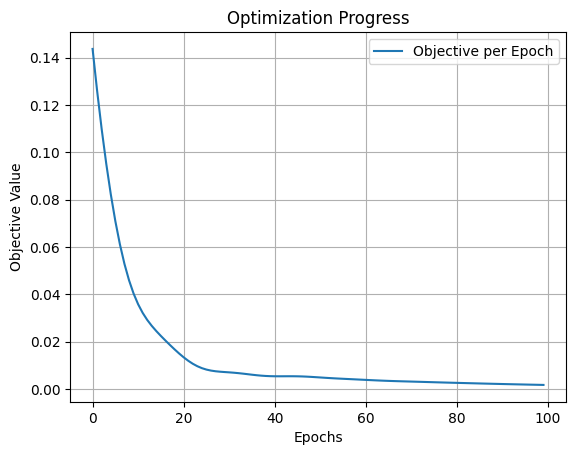

Final T: tensor([[-0.2252,  0.7039, -0.3883],
        [-0.1207,  0.2400, -1.1509]], requires_grad=True)


In [9]:
# Define initial values (replace with actual values from your environment)
mu_L    = torch.from_numpy(mu_U_ll_hat)
Sigma_L = torch.from_numpy(Sigma_U_ll_hat)

mu_H    = torch.from_numpy(mu_U_hl_hat)
Sigma_H = torch.from_numpy(Sigma_U_hl_hat)

l = mu_L.shape[0]
h = mu_H.shape[0]

num_intervs = len(Ill)

# Define T as a tensor with requires_grad=True for automatic differentiation
T = torch.randn(h, l, requires_grad=True)

# Define the optimizer
optimizer = torch.optim.Adam([T], lr=0.01)
#optimizer = torch.optim.SGD([T], lr=0.01)

# Number of iterations (epochs)
num_epochs = 100  

# List to store the objective values at each epoch
objective_values = []

for epoch in range(num_epochs):
    # Initialize the objective for this iteration
    objective = 0
    
    # Compute the objective function as the expectation over samples
    for i, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota].compute_mechanism())
        H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism())
        
        # 1st term: || T (L_i * mu_L) - (H_i * mu_H) ||_2^2
        L_i_mu_L = L_i @ mu_L  # Result: (m,)
        H_i_mu_H = H_i @ mu_H  # Result: (n,)
        
        term1 = torch.norm(T.float() @ L_i_mu_L.float() - H_i_mu_H.float())**2  # Now this is dimensionally consistent
        
        # 2nd term: Tr(T L_i Sigma_L L_i^T T^T)
        term2 = torch.trace(T.float() @ L_i.float() @ Sigma_L.float() @ L_i.T.float() @ T.T.float())
        
        # 3rd term: Tr(H_i Sigma_H H_i^T)
        term3 = torch.trace(H_i.float() @ Sigma_H.float() @ H_i.T.float())
        
        # Ensure positive-definiteness for Cholesky decomposition
        L_i_Sigma_L = T.float() @ L_i.float() @ Sigma_L.float() @ L_i.T.float() @ T.T.float()
        H_i_Sigma_H = H_i.float() @ Sigma_H.float() @ H_i.T.float()
        
        # 4th term: -2 * || (T L_i Sigma_L L_i^T T^T)^(1/2) * (H_i Sigma_H H_i^T)^(1/2) ||_*
        term4 = -2 * torch.norm(torch.linalg.cholesky(L_i_Sigma_L) @ torch.linalg.cholesky(H_i_Sigma_H), 'nuc')

        # Sum up terms
        objective += term1 + term2 + term3 + term4

    # Average the objective over all interventions
    objective /= num_intervs

    # Append the objective value at this epoch
    objective_values.append(objective.item())

    # Compute gradients (subgradients for nuclear norm)
    optimizer.zero_grad()  # Zero out previous gradients
    objective.backward()  # Backpropagate to compute gradients

    print(f"Epoch {epoch+1}/{num_epochs}, Objective: {objective.item()}")

    # Perform one step of gradient descent
    optimizer.step()  # Update T using the optimizer

# After the loop, plot the objective values per epoch
plt.plot(range(num_epochs), objective_values, label='Objective per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Objective Value')
plt.title('Optimization Progress')
plt.grid(True)
plt.legend()
plt.show()

print("Final T:", T)

In [9]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

In [112]:
# # Define the update functions
# def update_mu_L(LLmodels, HLmodels, mu_H, lambda_eps, mu_U_ll_hat):
#     N = len(LLmodels)
#     E_LL = sum(LL_i.T @ LL_i for LL_i in LLmodels) / N
#     E_LH_mu_H = sum(LL_i.T @ HL_i @ mu_H for LL_i, HL_i in zip(LLmodels, HLmodels)) / N
#     reg_term = (lambda_eps / 2) * np.eye(mu_U_ll_hat.shape[0])
#     mu_L_expr = np.linalg.inv(E_LL + reg_term) @ (E_LH_mu_H + (lambda_eps / 2) * mu_U_ll_hat)
#     return mu_L_expr

# def update_mu_H(HLmodels, LLmodels, mu_L, lambda_delta, mu_U_hl_hat):
#     N = len(HLmodels)
#     E_HH = sum(HL_iota.T @ HL_iota for HL_iota in HLmodels) / N
#     E_HL_mu_L = sum(HL_iota.T @ LL_iota @ mu_L for LL_iota, HL_iota in zip(LLmodels, HLmodels)) / N
#     reg_term = (lambda_delta / 2) * np.eye(mu_U_hl_hat.shape[0])
#     mu_H_expr = np.linalg.inv(E_HH + reg_term) @ (E_HL_mu_L + (lambda_delta / 2) * mu_U_hl_hat)
#     return mu_H_expr

# def update_Sigma_L(LLmodels, lambda_eps, Sigma_U_ll_hat, lambda_Q, Sigma_L_k):
#     # Ensure that lambda_eps is a scalar or a single value
#     if np.isscalar(lambda_eps) or lambda_eps.size == 1:
#         lambda_eps_value = lambda_eps if np.isscalar(lambda_eps) else lambda_eps.item()
#         if lambda_eps_value > 0:
#             # Check shapes of LLmodels and lambda_Q
#             LL_sum = np.sum([LL_i @ LL_i.T for LL_i in LLmodels], axis=0)  # Should result in (4, 4) if each LL_i is (4, 3)
#             lambda_Q_sum = np.sum(lambda_Q, axis=0)  # Ensure this matches the expected shape
            
#             # Make sure lambda_Q_sum is shaped correctly for the operation
#             if lambda_Q_sum.shape != LL_sum.shape:
#                 raise ValueError(f"Shape mismatch: LL_sum shape {LL_sum.shape} and lambda_Q_sum shape {lambda_Q_sum.shape}")

#             Sigma_L_updated = np.linalg.inv(LL_sum + lambda_eps_value * np.eye(Sigma_L_k.shape[0])) @ (
#                 lambda_eps_value * Sigma_U_ll_hat + lambda_Q_sum
#             )
#         else:
#             Sigma_L_updated = np.zeros_like(Sigma_L_k)  # Handle the case where the condition is not met
#     else:
#         raise ValueError("lambda_eps should be a scalar or a single value")

#     return Sigma_L_updated

# def update_Sigma_H(HLmodels, lambda_delta, Sigma_U_hl_hat, lambda_W, Sigma_H_k):
#     if np.isscalar(lambda_delta) or lambda_delta.size == 1:
#         lambda_delta_value = lambda_delta if np.isscalar(lambda_delta) else lambda_delta.item()
#         if lambda_delta_value > 0:
#             Sigma_H_updated = np.linalg.inv(np.sum(HLmodels, axis=0) + lambda_delta_value * np.eye(Sigma_H_k.shape[0])) @ (lambda_delta_value * Sigma_U_hl_hat + np.sum(lambda_W, axis=0))
#         else:
#             Sigma_H_updated = np.zeros_like(Sigma_H_k)
#     else:
#         raise ValueError("lambda_delta should be a scalar or a single value")
#     return Sigma_H_updated

# def update_Q_i(Q_i_k, lambda_Q_i, rho_Q, alpha):
#     norm_Q = np.linalg.norm(Q_i_k, 'fro')
#     if norm_Q > alpha:
#         Q_i_updated = (1 - (alpha / norm_Q)) * (Q_i_k - (1 / rho_Q) * lambda_Q_i)
#     else:
#         Q_i_updated = np.zeros_like(Q_i_k)
#     return Q_i_updated

# def update_W_i(W_i_k, lambda_W_i, rho_W, alpha):
#     norm_W = np.linalg.norm(W_i_k, 'fro')
#     if norm_W > alpha:
#         W_i_updated = (1 - (alpha / norm_W)) * (W_i_k - (1 / rho_W) * lambda_W_i)
#     else:
#         W_i_updated = np.zeros_like(W_i_k)
#     return W_i_updated

# def update_lambda_Q(lambda_Q_i_k, rho_Q, Q_i_k_plus_1, LL_i, Sigma_L_k_plus_1):
#     term = np.sqrt(LL_i @ Sigma_L_k_plus_1 @ LL_i.T)
#     lambda_Q_i_updated = lambda_Q_i_k + rho_Q * (Q_i_k_plus_1 - term)
#     return lambda_Q_i_updated

# def update_lambda_W(lambda_W_i_k, rho_W, W_i_k_plus_1, HL_i, Sigma_H_k_plus_1):
#     term = np.sqrt(HL_i @ Sigma_H_k_plus_1 @ HL_i.T)
#     lambda_W_i_updated = lambda_W_i_k + rho_W * (W_i_k_plus_1 - term)
#     return lambda_W_i_updated

# def update_lambda_epsilon(lambda_eps_k, mu_L_k_plus_1, mu_U_ll_hat, Sigma_L_k_plus_1, Sigma_U_ll_hat, epsilon):
#     lambda_eps_updated = lambda_eps_k + (epsilon**2 - np.linalg.norm(mu_L_k_plus_1 - mu_U_ll_hat)**2 - np.linalg.norm(np.sqrt(Sigma_L_k_plus_1) - np.sqrt(Sigma_U_ll_hat))**2)
#     return lambda_eps_updated

# def update_lambda_delta(lambda_del_k, mu_H_k_plus_1, mu_U_hl_hat, Sigma_H_k_plus_1, Sigma_U_hl_hat, delta):
#     lambda_del_updated = lambda_del_k + (delta**2 - np.linalg.norm(mu_H_k_plus_1 - mu_U_hl_hat)**2 - np.linalg.norm(np.sqrt(Sigma_H_k_plus_1) - np.sqrt(Sigma_U_hl_hat))**2)
#     return lambda_del_updated

# def compute_monge_map(mu_a, Sigma_a, mu_b, Sigma_b):
#     # Check dimensions
#     if mu_a.shape[0] != 3 or mu_b.shape[0] != 2:
#         raise ValueError("Mean vectors must be of shape (3,) for Gaussian A and (2,) for Gaussian B.")
    
#     if Sigma_a.shape != (3, 3) or Sigma_b.shape != (2, 2):
#         raise ValueError("Covariance matrices must be of shape (3, 3) for Gaussian A and (2, 2) for Gaussian B.")

#     # Compute the square root of the covariance matrices
#     Sigma_a_sqrt = np.linalg.cholesky(Sigma_a)

#     # Use a 2D projection from 3D to 2D, we need a method to match the dimensions
#     # Here we assume a simple linear map for projection
#     A = Sigma_a_sqrt[:2, :2]  # Take the first two rows/columns for the projection

#     # Compute the transformation matrix
#     A_inv = np.linalg.inv(A)
#     B_inv = np.linalg.inv(Sigma_b)
    
#     # Calculate the optimal transformation using the covariance matrices
#     transformation_matrix = A_inv @ Sigma_b @ A_inv

#     # Compute the inverse square root of the transformation matrix
#     transformation_matrix_sqrt_inv = np.linalg.inv(np.linalg.cholesky(transformation_matrix))

#     def T(x):
#         # Ensure the input x is in the expected shape (3,)
#         if x.shape[0] != 3:
#             raise ValueError("Input x must be a 3D vector (shape: (3,)).")
#         # Map the 3D vector to 2D
#         return transformation_matrix_sqrt_inv @ (x - mu_a)[:2] + mu_b

#     return T

In [20]:
# # Optimization Parameters Initialization
# num_iterations = 100000  # Number of iterations for optimization
# rho_Q = 1.0  # Penalty parameter for Q updates
# rho_W = 1.0  # Penalty parameter for W updates
# alpha = 0.5  # Proximal parameter
# epsilon = 0.1  # Epsilon constraint value
# delta = 0.1  # Delta constraint value

# # Example initialization (replace these with actual data)
# LLmodels = [np.random.rand(4, 3) for _ in range(5)]  # Example L_i matrices
# HLmodels = [np.random.rand(4, 2) for _ in range(5)]  # Example H_i matrices
# mu_U_ll_hat = np.random.rand(3)  # Target mean for mu_L
# mu_U_hl_hat = np.random.rand(2)  # Target mean for mu_H
# Sigma_U_ll_hat = np.eye(3)  # Target covariance for Sigma_L
# Sigma_U_hl_hat = np.eye(2)  # Target covariance for Sigma_H

# # Initialize variables
# mu_L = np.random.rand(3)  # Initial estimate for mu_L
# mu_H = np.random.rand(2)  # Initial estimate for mu_H
# Sigma_L = np.eye(3)  # Initial estimate for Sigma_L
# Sigma_H = np.eye(2)  # Initial estimate for Sigma_H
# Q_vars = [np.random.rand(4, 4) for _ in range(5)]  # Initial Q matrices
# W_vars = [np.random.rand(4, 4) for _ in range(5)]  # Initial W matrices
# lambda_Q = [np.zeros((4, 4)) for _ in range(5)]  # Initial lambda_Q
# lambda_W = [np.zeros((4, 4)) for _ in range(5)]  # Initial lambda_W
# lambda_eps = 0.0  # Initial lambda_eps
# lambda_del = 0.0  # Initial lambda_delta

# # Optimization Loop
# for k in range(num_iterations):
#     # Update mu_L and mu_H
#     mu_L = update_mu_L(LLmodels, HLmodels, mu_H, lambda_eps, mu_U_ll_hat)
#     mu_H = update_mu_H(HLmodels, LLmodels, mu_L, lambda_delta, mu_U_hl_hat)

#     # Update Sigma_L and Sigma_H
#     Sigma_L = Sigma_U_ll_hat #update_Sigma_L(LLmodels, rho_Q, Sigma_U_ll_hat, lambda_Q, Sigma_L)
#     Sigma_H = Sigma_U_hl_hat #update_Sigma_H(HLmodels, rho_W, Sigma_U_hl_hat, lambda_W, Sigma_H)

#     # Update Q and W
#     for iota in range(len(Q_vars)):
#         Q_vars[iota] = update_Q_i(Q_vars[iota], lambda_Q[iota], rho_Q, alpha)
#         W_vars[iota] = update_W_i(W_vars[iota], lambda_W[iota], rho_W, alpha)

#     # Update lambda multipliers
#     for iota in range(len(Q_vars)):
#         lambda_Q[iota] = update_lambda_Q(lambda_Q[iota], rho_Q, Q_vars[iota], LLmodels[iota], Sigma_L)
#         lambda_W[iota] = update_lambda_W(lambda_W[iota], rho_W, W_vars[iota], HLmodels[iota], Sigma_H)

#     # Update lambda_eps and lambda_delta
#     lambda_eps = update_lambda_epsilon(lambda_eps, mu_L, mu_U_ll_hat, Sigma_L, Sigma_U_ll_hat, epsilon)
#     lambda_del = update_lambda_delta(lambda_del, mu_H, mu_U_hl_hat, Sigma_H, Sigma_U_hl_hat, delta)

# # Print the final results
# print("Final mu_L:", mu_L)
# print("Final Sigma_L:\n", Sigma_L)
# print("Final mu_H:", mu_H)
# print("Final Sigma_H:\n", Sigma_H)
# print( )
# tau = compute_monge_map(mu_L, Sigma_L, mu_H, Sigma_H)
# x_sample = np.array([1.5, 2.5, 3.5])
# mapped_point = tau(x_sample)

# print("Mapped point:", mapped_point)

In [9]:
def update_mu_L(mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L, eta):
    grad_mu_L = torch.zeros_like(mu_L, dtype=torch.float32) 
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota].compute_mechanism()).float() 
        V_i = T @ L_i  
        H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism()).float() 

        grad_mu_L += torch.matmul(V_i.T, torch.matmul(V_i, mu_L.float()) - torch.matmul(H_i, mu_H.float())) 
    
    grad_mu_L = (2 / n) * grad_mu_L - 2 * lambda_L * (mu_L - hat_mu_L)
    mu_L += eta * grad_mu_L
    return mu_L

def update_mu_H(mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H, eta):
    grad_mu_H = torch.zeros_like(mu_H, dtype=torch.float32)  
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota].compute_mechanism()).float()  
        V_i = T @ L_i  
        H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism()).float()  

        grad_mu_H -= torch.matmul(H_i.T, torch.matmul(V_i, mu_L.float()) - torch.matmul(H_i, mu_H.float()))
    
    grad_mu_H = (2 / n) * grad_mu_H - 2 * lambda_H * (mu_H - hat_mu_H)
    
    mu_H += eta * grad_mu_H
    return mu_H


def update_Sigma_L_half(Sigma_L, LLmodels, lambda_L, hat_Sigma_L, eta):
    grad_Sigma_L = torch.zeros_like(Sigma_L)
    
    # Term 1: (2/n) * sum_i(V_i^T * V_i)
    term1 = torch.zeros_like(Sigma_L)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota].compute_mechanism())
        V_i = T @ L_i.float()
        term1 += torch.matmul(V_i.T, V_i)

    # Term 2: -2 * lambda_L * (Sigma_L^(1/2) - hat_Sigma_L^(1/2)) * Sigma_L^(-1/2)
    Sigma_L_sqrt = oput.sqrtm_svd(Sigma_L)  # Compute the square root of Sigma_L
    #Sigma_L_sqrt = torch.linalg.matrix_power(Sigma_L, 0.5)

    hat_Sigma_L_sqrt = oput.sqrtm_svd(hat_Sigma_L)  # Compute the square root of hat_Sigma_L

    term2 = -2 * lambda_L * (Sigma_L_sqrt - hat_Sigma_L_sqrt) @ torch.inverse(Sigma_L_sqrt)

    # Combine terms
    grad_Sigma_L = (2 / n) * term1 + term2

    # Update Sigma_L
    Sigma_L_half = Sigma_L + eta * grad_Sigma_L
    #Sigma_L_half  = diagonalize(Sigma_L_half)
    return Sigma_L_half


def update_Sigma_L(Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param):
    Sigma_L_final = torch.zeros_like(Sigma_L_half, dtype=torch.float32)  
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota].compute_mechanism()).float()  
        V_i = T @ L_i  
        H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism()).float()  
        
        Sigma_L_half      = Sigma_L_half.float()
        V_Sigma_V         = torch.matmul(V_i, torch.matmul(Sigma_L_half, V_i.T))
        sqrtm_V_Sigma_V   = oput.sqrtm_svd(V_Sigma_V)
        prox_Sigma_L_half = torch.matmul(oput.prox_operator(sqrtm_V_Sigma_V, lambda_param), oput.prox_operator(sqrtm_V_Sigma_V, lambda_param).T)
        ll_term           = torch.matmul(torch.matmul(torch.linalg.pinv(V_i), prox_Sigma_L_half), torch.linalg.pinv(V_i).T)

        Sigma_H   = Sigma_H.float()  
        H_Sigma_H = torch.matmul(H_i, torch.matmul(Sigma_H, H_i.T)).float()
        hl_term   = torch.norm(oput.sqrtm_svd(H_Sigma_H), p='fro')

        Sigma_L_final += ll_term * hl_term

    Sigma_L_final *=  (2 / n)
    Sigma_L_final = oput.diagonalize(Sigma_L_final)

    return Sigma_L_final


def update_Sigma_H_half(Sigma_H, HLmodels, lambda_H, hat_Sigma_H, eta):
    grad_Sigma_H = torch.zeros_like(Sigma_H)
    term1 = torch.zeros_like(Sigma_H)
    for n, iota in enumerate(Ill):
        H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism())

        term1 += torch.matmul(H_i.T, H_i)

    Sigma_H_sqrt     = oput.sqrtm_svd(Sigma_H)  
    hat_Sigma_H_sqrt = oput.sqrtm_svd(hat_Sigma_H) 

    term2 = -2 * lambda_H * (Sigma_H_sqrt - hat_Sigma_H_sqrt) @ torch.inverse(Sigma_H_sqrt)

    grad_Sigma_H = (2 / n) * term1 + term2

    Sigma_H_half = Sigma_H + eta * grad_Sigma_H
    return Sigma_H_half


def update_Sigma_H(Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param):
    Sigma_H_final = torch.zeros_like(Sigma_H_half)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota].compute_mechanism())
        V_i = T @ L_i.float()
        H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism()).float()

        H_Sigma_H         = torch.matmul(H_i, torch.matmul(Sigma_H_half, H_i.T))
        sqrtm_H_Sigma_H   = oput.sqrtm_svd(H_Sigma_H)
        prox_Sigma_H_half = torch.matmul(oput.prox_operator(sqrtm_H_Sigma_H, lambda_param), oput.prox_operator(sqrtm_H_Sigma_H, lambda_param).T)
        hl_term           = torch.matmul(torch.matmul(torch.inverse(H_i), prox_Sigma_H_half), torch.inverse(H_i).T)  

        
        V_Sigma_V = torch.matmul(V_i, torch.matmul(Sigma_L, V_i.T))
        ll_term   = torch.norm(oput.sqrtm_svd(V_Sigma_V))

        Sigma_H_final += ll_term * hl_term
    
    Sigma_H_final *= (2 / n)
    Sigma_H_final  = oput.diagonalize(Sigma_H_final)
    
    return Sigma_H_final

In [10]:
def optimize(mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, lambda_L, lambda_H, lambda_param, eta, max_iter):
    objective_values = []  
    for t in range(max_iter):        
        # Update mu_L and mu_H
        mu_L = update_mu_L(mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L, eta)
        mu_H = update_mu_H(mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H, eta)
        # Update Sigma_L (t+1/2, t)
        Sigma_L_half = update_Sigma_L_half(Sigma_L, LLmodels, lambda_L, hat_Sigma_L, eta)
        Sigma_L      = update_Sigma_L(Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param)
                
        # Update Sigma_H (t+1/2, t)
        Sigma_H_half = update_Sigma_H_half(Sigma_H, HLmodels, lambda_H, hat_Sigma_H, eta)
        Sigma_H      = update_Sigma_H(Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param)
        
        # Compute the objective function for the current iteration
        objective = 0
        
        for i, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota].compute_mechanism())
            V_i = T @ L_i.float()
            H_i = torch.from_numpy(HLmodels[omega[iota]].compute_mechanism()).float()
                        
            L_i_mu_L = V_i @ mu_L
            H_i_mu_H = H_i @ mu_H
            term1 = torch.norm(L_i_mu_L.float() - H_i_mu_H.float())**2
            
            V_Sigma_V = V_i.float() @ Sigma_L.float() @ V_i.T.float()
            H_Sigma_H = H_i.float() @ Sigma_H.float() @ H_i.T.float()

            term2 = torch.trace(V_Sigma_V)
            term3 = torch.trace(H_Sigma_H)
            
            sqrtVSV = oput.sqrtm_svd(V_Sigma_V)
            sqrtHSH = oput.sqrtm_svd(H_Sigma_H)

            #term4 = -2*torch.trace(oput.sqrtm_svd(sqrtHSH @ V_Sigma_V @ sqrtHSH))
            term4 = -2*torch.norm(oput.sqrtm_svd(sqrtVSV) @ oput.sqrtm_svd(sqrtHSH), 'nuc')
            
            objective += term1 + term2 + term3 + term4
        
        objective /= i
        
        objective_values.append(objective.item())
        
        # Print progress every 10 iterations
        if t % 10 == 0:
            print(f"Iteration {t}, Objective: {objective.item()}")
    
    # After the optimization loop, plot the objective values
    plt.plot(range(max_iter), objective_values, label='Objective per Iteration')
    plt.xlabel('Iterations')
    plt.ylabel('Objective Value')
    plt.title('Optimization Progress')
    plt.grid(True)
    plt.legend()
    plt.show()

    print("Final mu_L:", mu_L)
    print("Final Sigma_L:", Sigma_L)
    print("Final mu_H:", mu_H)
    print("Final Sigma_H:", Sigma_H)

    return mu_L, Sigma_L, mu_H, Sigma_H


In [11]:
hat_mu_L    = torch.from_numpy(mu_U_ll_hat).float()
hat_Sigma_L = torch.from_numpy(Sigma_U_ll_hat).float()

hat_mu_H    = torch.from_numpy(mu_U_hl_hat).float()
hat_Sigma_H = torch.from_numpy(Sigma_U_hl_hat).float()

l = hat_mu_L.shape[0]
h = hat_mu_H.shape[0]

# # Random initialization
# mu_L0    = torch.randn(l).float() 
# Sigma_L0 = torch.eye(l).float()  

# mu_H0    = torch.randn(h).float()
# Sigma_H0 = torch.eye(h).float()

# # Initialization based on the empirical means and covariances
# mu_L0    = hat_mu_L
# Sigma_L0 = hat_Sigma_L 

# mu_H0    = hat_mu_H
# Sigma_H0 = hat_Sigma_H

# Gelbrich initialization
ll_moments      = mut.sample_moments_U(mu_hat = mu_U_ll_hat, Sigma_hat = Sigma_U_ll_hat, bound = epsilon, num_envs = 1)
mu_L0, Sigma_L0 = ll_moments[0]
#mu_L0, Sigma_L0 = torch.from_numpy(mu_L0), torch.from_numpy(Sigma_L0)

hl_moments      = mut.sample_moments_U(mu_hat = mu_U_hl_hat, Sigma_hat = Sigma_U_hl_hat, bound = delta, num_envs = 1)
mu_H0, Sigma_H0 = hl_moments[0]
#mu_H0, Sigma_H0 = torch.from_numpy(mu_H0), torch.from_numpy(Sigma_H0)


T = torch.exp(torch.from_numpy(np.random.randn(2, 3)).float())

In [25]:
#np.random.seed(0)

Iteration 0, Objective: 67.76513671875
Iteration 10, Objective: 686.5377807617188
Iteration 20, Objective: 877.89404296875
Iteration 30, Objective: 890.74755859375
Iteration 40, Objective: 891.4981689453125
Iteration 50, Objective: 891.5418701171875
Iteration 60, Objective: 891.5445556640625
Iteration 70, Objective: 891.54443359375
Iteration 80, Objective: 891.5446166992188
Iteration 90, Objective: 891.5447387695312


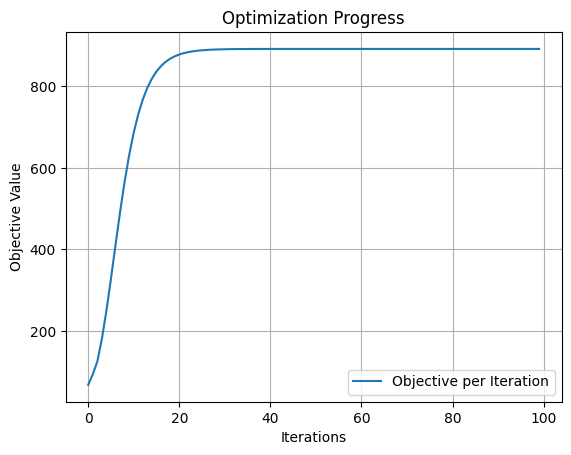

Final mu_L: tensor([-0.0056, -0.0122, -0.0010])
Final Sigma_L: tensor([[ 0.1174,  0.0000,  0.0000],
        [ 0.0000, 23.6230,  0.0000],
        [ 0.0000,  0.0000, 24.1165]])
Final mu_H: tensor([ 0.0097, -0.0082])
Final Sigma_H: tensor([[51.7379,  0.0000],
        [ 0.0000, 51.7362]])


In [26]:
mu_L    = torch.from_numpy(mu_L0).float()
Sigma_L = torch.from_numpy(Sigma_L0).float()
mu_H    = torch.from_numpy(mu_H0).float()
Sigma_H = torch.from_numpy(Sigma_H0).float()

mu_L, Sigma_L, mu_H, Sigma_H = optimize(mu_L, Sigma_L, mu_H, Sigma_H, LLmodels,
                                             HLmodels, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                                             lambda_L=200, lambda_H=200, lambda_param=0.9, eta=0.001, max_iter=100)

In [21]:
# Check if the parameters satisfy the constraints and get violation amounts
satisfied, violation_1, violation_2 = oput.check_constraints(mu_L, Sigma_L, mu_H, Sigma_H, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, epsilon, delta)

print("Constraints satisfied:", satisfied)
print("Violation of constraint 1:", violation_1)
print("Violation of constraint 2:", violation_2)

Constraints satisfied: False
Violation of constraint 1: 27.441503524780273
Violation of constraint 2: 76.772216796875
